In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
words = open('names.txt','r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [17]:
len(words)

32033

In [18]:
# building the vocabulary with mapping from characters to integers and vice-versa
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [129]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one
X, Y = [], []

for w in words:
    
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # cropping and appending

X = torch.tensor(X)
Y = torch.tensor(Y)

In [130]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [131]:
# building the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one
    X, Y = [], []

    for w in words:
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # cropping and appending

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [157]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator = g)

W1 = torch.randn((30, 200), generator = g)
b1 = torch.randn(200, generator  =g)
W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2] 


In [158]:
sum(p.nelement() for p in parameters) # getting the number of parameters

11897

In [159]:
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

# we will not use this way to index else will use ways like C[i]

C[torch.tensor([5, 6, 7])]

# indexing can be done through a tensor

tensor([[ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
         -0.9103, -0.7830],
        [ 0.1351, -0.2116, -1.0406, -1.5367,  0.9374, -0.8830,  1.7457,  2.1346,
         -0.8561,  0.5408],
        [ 0.6169,  1.5160, -1.0447, -0.6641, -0.7239,  1.7507,  0.1753,  0.9928,
         -0.6279,  0.0770]])

In [160]:
for p in parameters:
    p.requires_grad = True

In [161]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [162]:

lri  = []
lossi = []
stepi = []

In [167]:
# due to the magical powers of indexing in pytorch, we can just index all the inputs in X in one
# single line of code


for i in range(50000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # we do minibatching-> even though the gradient direction is not great, it is better to 
    # take more steps towards the gradients quickly rather than wait for a whole iteration

    # FORWARD PASS

    emb = C[Xtr[ix]]

    # torch.view is a very powerful tool to re-interpret a torch tensor
    h =  torch.tanh(emb.view(-1, 30) @ W1 + b1)  # pytorch interprets what -1 should be
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # forward and backward pass will be much more efficient
    # using cross_entropy instead of our softmax calculation ensures no numerical outflow


    # BACKWARD PASS

    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    lr = 0.01
    # UPDATE
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())  # log loss looks nicer, usual loss looks like a hockey stick

print(loss.item())

2.1425228118896484


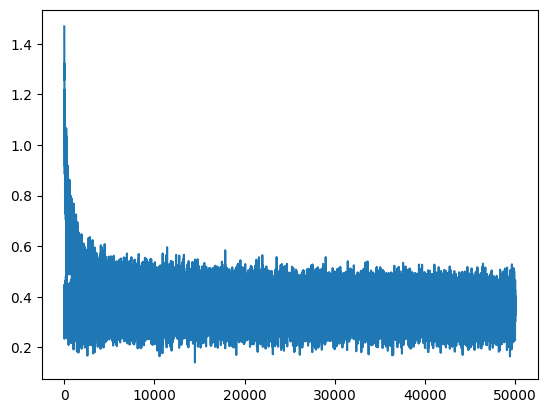

In [171]:
plt.plot(stepi, lossi)

In [169]:
# LOSS FOR TRAIN DATASET

emb = C[Xtr]
h =  torch.tanh(emb.view(-1, 30) @ W1 + b1)  # pytorch interprets what -1 should be
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss


tensor(2.1811, grad_fn=<NllLossBackward0>)

In [170]:
# LOSS FOR VALIDATION DATASET

emb = C[Xdev]
h =  torch.tanh(emb.view(-1, 30) @ W1 + b1)  # pytorch interprets what -1 should be
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss


# if training and dev losses are roughly equal, then we are probably underfitting. Then we can increase the number of parameters 

tensor(2.2255, grad_fn=<NllLossBackward0>)

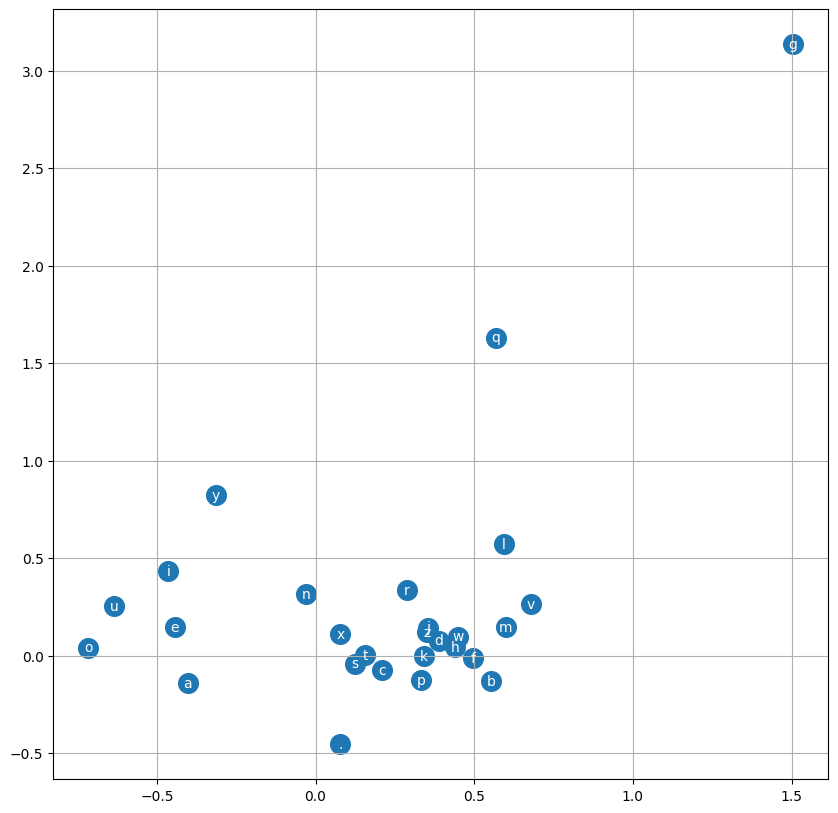

In [ ]:
# visualising the embeddings, works when embeddings are 2 dimensional
plt.figure(figsize = (10,10))
plt.scatter(C[:, 0].data, C[:, 1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha = "center", va ="center", color = "white")
plt.grid("minor")

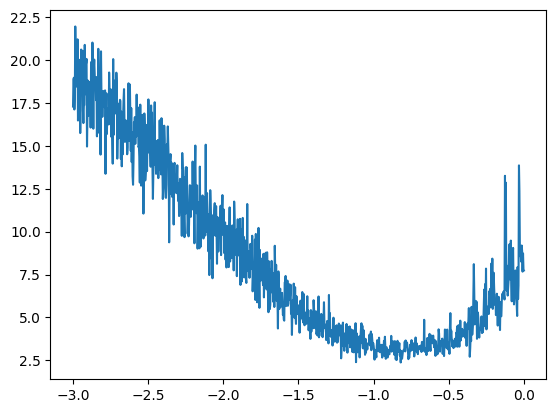

In [66]:
plt.plot(lri, lossi) # This is how you roughly approximate. Look at the learning rate range where there isn't much oscillation in the loss

In [173]:
# having all the data for training is a horrible idea
# so we usually have training split, dev/validation split, test split
# 80%, 10%, 10%



In [181]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h@W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out))

gielyn.
sten.
gizyn.
elus.
asziyanniyahni.
lego.
malaser.
lesiliochiann.
city.
cetrie.
katovistife.
aneel.
keyton.
abeutivin.
sten.
yyonni.
taliya.
poolandalija.
marria.
tavganya.
